# Derivativos de Taxa de Juros
## Modelo de Kalotay-Williams-Fabozzi

Renato Mori, Uirá Caiado. 19 de Junho, 2016

**Resumo**

*Neste projeto vamos implementar um modelo de um fator chamado [Kalotay-Williams-Fabozzi](https://en.wikipedia.org/wiki/Short-rate_model#One-factor_short-rate_models), onde apenas um único fator estocástico - a taxa de juros instantânea - determina a evolução de toda estrutura a termo da taxa de juros. Vamos descrever brevemente o modelo, detalhar sua implementação, estimar seus parâmetros e demonstrar sua utilização para precificação de alguns títulos que sejam possíveis de compara com preços de mercado.*

## 1. Introdução

Nesta sessão vamos introduzir o modelo discutido neste trabalho e descrever o problema que será abordado aqui.


### 1.1. Modelagem da Curva de Juros

Como colocado por Fabozzi, a Taxa de Juros frequentemente é modelada usando equações diferenciais estocásticas ([SDEs](https://en.wikipedia.org/wiki/Stochastic_differential_equation) é a abreviação em inglês). Os modelos mais comumente utilizados são os modelos de um ou dois fatores (estocástios), sendo que o de um usa uma SDE para representar a taxa de juros de curto prazo e a segunda representa tanto a taxa de curto como a de longo prazo. Na dinâmica escolhida para o modelo que deve ser refletidas as características desejadas para a curva, como reversão a média e volatilidade dependente do nível da taxa.

Existe duas abordagens para na utilizaçtão de equações estocásticas na modelagem da curva a termo de juros: modelos de equilibrio e modelos de não arbitragem, sendo que ambos são usados para precificar *Bonds* e derivativos sobre taxa de juros.

Modelos de equilíbrio começam com uma SDE e desenvolvem uma estrutura que não necessariamente correspondem aos preços observados no mercado. Alguns exemplos de modelos desta classe são o Vasicek, Brenna and Schwartz e o Cox, Ingersoll and Ross.

Os modelos de não arbitragem também utilizam uma SDE, porém usam os preços de mercado para gerar os caminhos possíveis para taxa de juros. Esta estrutura segue as características impostas pela SDE as taxas de juros encontradas, quando usadas para precificar um bond qualquer, resultam na mesma taxa de juros observada no mercado. Exemplos são o Ho and Lee, Black, Derman and Toy e o Hull and White.

Os modelos de não arbitragem geralmente são escolhidos para precificação de Bonds e derivativos pois garantem que as taxas atuais correspondam ao mercado. Este trabalgho explorará um modelo de não arbitragem chamado Kalotay-Williams-Fabozzi.

### 1.2. Modelo Kalotay-Williams-Fabozzi

O modelo Kalotay-Williams-Fabozzi (KWF) assume que as mudanças na taxa de juros de curto prazo segue um certo [processo estocástico](https://en.wikipedia.org/wiki/Stochastic_process) que pode ser descrito pela seguinte SDE:

$$ \mathrm{d} \ln \left (  r(t) \right ) = \theta(t) \mathrm{d} t + \sigma\mathrm{d}Z$$

Onde $Z$ é um processo de [Wiener](https://en.wikipedia.org/wiki/Wiener_process), $\theta$ é o *drift* do processo e $\sigma$ é a volatilidade da primeira diferença das taxas de curto prazo.  Como o que a equação descreve é a dinâmica do **logarítimo natural** de taxa $r$; e $W$ tem distribuição normal, o $\ln(r)$ terá distribuição normal e o $r$, log normal. Desta maneira, embora $\ln(r)$ possa assumir valores negativos, $r$ não assumirá.

No trabalho original em que o modelo KWF foi apresentado, os autores não incluiram explicitamente o *drift* na dinâmica do processo na modelagem e, por tanto, também não utilizaremos ele aqui. Assim, assumindo $\theta=0$, integrando ambos os lados da SDE, chamando $\ln(r)$ de $f(t)$ e sabendo que $W_t - W_s = W_{t-s}$, ficamos com:

\begin{equation}
    \begin{aligned}
    \int_{t}^{T}{\mathrm{d} f(t)} &=  \sigma \int_{t}^{T}{\mathrm{d}W_{t}} \\
    f(T) - f(t) &= \sigma \left (  W_{T} - W_{t} \right ) \\
    \ln \left (  r(T) \right ) - \ln \left (  r(t) \right ) &= \sigma \left (  W_{T} - W_{t} \right )\\
    r(T) &= r(t) \cdot e^{\sigma \cdot W_{T-t}}
    \end{aligned}
\end{equation}

Na proxima seção, discretizaremos este processo e implementaremos este modelo.

## 2. Implementando o Modelo

Nesta sessão detalharemos e implementaremos o modelo utilizando como referência o artigo original e calibraremos ele para que bata com os dados de mercado.

### 2.1. Aproximação da SDE por Árvore Binomial

As equações diferenciais estocásticas podem ter sua solução aproximada numericamente utilizando uma árvore binomial. Este método assume que a taxa de juros de curto prazo pode assumir apenas dois valores no período seguinte da discretização, $r_{u}$ ou $r_{d}$, onde $r_{u} > r_{d}$. Como cada nó da árvore dá origem à dois novos nós, a medida que se aumenta os passos de discretização, o número de nós aumenta rapidamente, resultando em uma árvore com $2^{\,\,passos-1}$ nós no último passo da árvore, cado um representando uma evolução específica da taxa.

Para evitar este crescimento exponencial, é imposto ao modelo que a árvore seja recombinante, ou seja, um movimento de subida seguido por uma queda resulta no mesmo nó de uma queda seguida de uma alta. Isto reduz a árvore para a ter a mesma quantidade de nós que tem de passos no último estágio. Um movimento de alta na taxa de juros tem probabilidade $q$ de ocorrer, enquanto um de queda tem probabilidade de $1 - q$. Combinando cada nó com sua respectiva probabilidade, esta árvore é eqivalente à árvore não recombinante. 

Utilizaremos probabilidade de $q=0.5$ para garantir a neutralidade a risco na solução da SDE. É importante frisar que isso não implica na probabilidade real da taxa de juros cair. A probabilidade $q$ representa apenas a probabilidade no mundo [*neutro a risco*](https://en.wikipedia.org/wiki/Risk-neutral_measure). Abaixo, vamos testar a estrtutura criada para representar uma árvore binomial. Como será demonstrado, o total de nós criados é equivalente a $\sum_{i=1}^{n+1}{i}$, onde $n$ é a quantidade de passos.

In [309]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [311]:
import time
import binomial_tree; reload(binomial_tree);

def foo(i):
    f_start = time.time()
    x = binomial_tree.BinomialTree(i)
    x._go_foward(i)
    i_rtn = len(x.set_of_nodes)
    return i_rtn, time.time() - f_start

print "Tempo para inicar toda a arvore: "
for i in [10, 100, 250, 500, 1000]:
    # mais de 1000 nodes trava
    i_nodes, f_time = foo(i)
    print u"- Com {} passos: Criados {:0,.0f} nós em {:.2f} segundos".format(i, i_nodes, f_time)

Tempo para inicar toda a arvore: 
- Com 10 passos: Criados 66 nós em 0.00 segundos
- Com 100 passos: Criados 5,151 nós em 0.10 segundos
- Com 250 passos: Criados 31,626 nós em 0.45 segundos
- Com 500 passos: Criados 125,751 nós em 2.39 segundos
- Com 1000 passos: Criados 501,501 nós em 10.19 segundos


A propriedade da recombinação pode ser visualizada no diagrama abaixo:

In [69]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.BinomialTree(12)
x._go_foward(12)
print 'Primeiros passos da arvore criada:\n========================================\n\n'
print x

Primeiros passos da arvore criada:


								UUUUUUUU
							UUUUUUU	
						UUUUUU		DUUUUUUU
					UUUUU		DUUUUUU	
				UUUU		DUUUUU		DDUUUUUU
			UUU		DUUUU		DDUUUUU	
		UU		DUUU		DDUUUU		DDDUUUUU
	U		DUU		DDUUU		DDDUUUU	
_		DU		DDUU		DDDUUU		DDDDUUUU
	D		DDU		DDDUU		DDDDUUU	
		DD		DDDU		DDDDUU		DDDDDUUU
			DDD		DDDDU		DDDDDUU	
				DDDD		DDDDDU		DDDDDDUU
					DDDDD		DDDDDDU	
						DDDDDD		DDDDDDDU
							DDDDDDD	
								DDDDDDDD

Plotted 8 from 12 steps


### 2.2. Discretização o Modelo

Como pode ser visto no diagrama acima, a taxa $r_U$ está sempre $2$ nós distante da taxa $r_D$  (há um nó vazio entre elas). Como a dinâmica proposta é dinâmica $r(T) = r(t) \cdot e^{\sigma \cdot W_{T-t}}$, considerando que já possuímos o nó mais baixo, se utilizarmos $r_D$ como *proxy*, a taxa logo acima dela será $r_U=r_D\, e ^{\,2\sigma}$, onde $\sigma$ é a volatilidade constante da taxa [*forward*](http://www.investopedia.com/terms/f/forwardrate.asp) de um ano.

```
TODO: melhorar esse boloco. Preciso explicar ajuste proposto pelo Renato
```

Assim o modelo segue de maneira bem direta, itera os nós mais baixos de maneira que, ao atualizar os nós acima no mesmo passo e trazer o valor de um bond hipotético que pague cupons ugual ao valor da yield seja markoviado, ou seja, que $E\,[\,X_{t+1}] = X_t$. A iteração foi feita chutando valores ao redor de um ponto inicial (o juros de mercado) e minimizando os [erros quadrados](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html).

In [331]:
# dados originais do paper
import binomial_tree; reload(binomial_tree)
l_txindicativa = [0.035, 0.04, 0.045]
l_prazo = [1., 2., 3.]

my_tree = binomial_tree.KWFTree(l_txindicativa, l_prazo)
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=100.)
print my_tree

			UUU
		UU	
	U		DUU
_		DU	
	D		DDU
		DD	
			DDD



In [336]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     
_                 0.00   100.000     3.500    1.0000
D                 4.50    99.926     4.074    1.0000
U                 4.50    98.074     4.976    1.0000
DD                4.50    99.972     4.530    1.0000
DU                4.50    99.022     5.532    1.0000
UU                4.50    97.886     6.757    1.0000
DDD               4.50   100.000     0.000    1.0000
DDU               4.50   100.000     0.000    1.0000
DUU               4.50   100.000     0.000    1.0000
UUU               4.50   100.000     0.000    1.0000


Onde as taxas nos pontos D, DD e DDD foram obtidas por iteração. Utilizando a curva obtida acima, pode-se então calcular o preço de um bond hipotético que vale $\$\,100$ no vencimento e paga cupons de $\$\,5.25$ por ano.

In [338]:
import instruments; reload(instruments);
bond_example = instruments.Bond(f_face_value=100., f_cupon=5.25)
print "Preço do Bond: {:.2f}".format(bond_example.get_current_value(my_tree, 3))

Preço do Bond: 102.07


Abaixo realizamos o mesmo procedimento para fitar uma curva de LTNs. Utilizamos como referência os preços dos bonds no dia $13$ de Junho, que foram levantados pelo site da [ANBIMA](http://portal.anbima.com.br/Pages/home.aspx). Utilizamos $12$ vértices no total. O juros de um nó para outro e a volatilidade foram ajustados ao vencimento de cada ponto. Primeiro, vamos checar quanto temo a estrtutura criada leva para se ajustar aos vértices passados, utilizando bons hipotéticos com cupons nos juros de cada vértice.

In [49]:
import binomial_tree; reload(binomial_tree)
import pandas as pd
# definindo parametros
l_txindicativa = [14.152, 14.0265, 13.7596, 13.4663, 13.1995,
                  12.9729, 12.8001, 12.7250, 12.6541, 12.5649,
                  12.5653, 12.6005]
l_prazo = [9., 74., 136., 199., 260., 324., 385., 446., 509, 635., 758., 888.]
l_txindicativa = [x/100. for x in l_txindicativa]

In [22]:
# testa tempo
def foo():
    my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                    [x/252. for x in l_prazo])
    my_tree.fit_foward_curve(f_sigma=0.1)
    
%timeit foo()

1 loop, best of 3: 803 ms per loop


In [41]:
#cria arvore
import binomial_tree; reload(binomial_tree)
my_tree = binomial_tree.KWFTree([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)

In [42]:
my_tree.get_description()

                 cupon     valor     taxa      prazo     venc      sigma     
_                 0.00  1000.000    14.152    0.0357    0.0000    0.0000
D                 4.25  1032.765    12.622    0.0357    0.0357   10.0000
U                 4.25   968.216    15.417    0.0357    0.0357   10.0000
DD               31.08  1062.316    10.907    0.2579    0.2937   10.0000
DU               31.08  1005.360    13.321    0.2579    0.2937   10.0000
UU               31.08   941.862    16.271    0.2579    0.2937   10.0000
DDD              29.63  1084.957     9.373    0.2460    0.5397   10.0000
DDU              29.63  1035.224    11.448    0.2460    0.5397   10.0000
DUU              29.63   979.065    13.983    0.2460    0.5397   10.0000
UUU              29.63   916.580    17.079    0.2460    0.5397   10.0000
DDDD             30.11  1100.834     8.103    0.2500    0.7897   10.0000
...


Com a curva ajustada, vamos calcular os preços atuais de zeros-cupons que tem principal de $\$\,1.000$ para cada um dos vértices e comparar com os seguintes PUs:

In [43]:
for f_r, f_prazo in zip(l_txindicativa, l_prazo):
    f_aux = 1000./(1+f_r)**(f_prazo/252.)
    print "PU do prazo {:4.0f}: {:.2f}".format(f_prazo, f_aux)

PU do prazo    9: 995.28
PU do prazo   74: 962.19
PU do prazo  136: 932.79
PU do prazo  199: 905.05
PU do prazo  260: 879.93
PU do prazo  324: 854.85
PU do prazo  385: 831.92
PU do prazo  446: 808.97
PU do prazo  509: 786.10
PU do prazo  635: 742.12
PU do prazo  758: 700.45
PU do prazo  888: 658.24


In [44]:
# calcula precos dos bonds
import instruments; reload(instruments);
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
for i in xrange(1, 13):
    print "{}: {:5.2f}".format(i, bond_example.get_current_value(my_tree, i_steps=i))

1: 995.28
2: 962.19
3: 932.81
4: 905.13
5: 880.12
6: 855.17
7: 832.39
8: 809.52
9: 786.74
10: 742.89
11: 701.18
12: 658.79


Como observado, os valores ficam muito próximos, porém ainda não condizem com os valores de mercado. Para garantir que o modelo convirja para os preços desejados, ao invés de calcularmos um bond hipotético que paga cupons para fazermos a aproximação, faremos com um zero cupon e imporemos que o modelo convirja para os PUs originais.

In [50]:
#cria arvore
import binomial_tree; reload(binomial_tree)
my_tree = binomial_tree.KWFTreePU([x for x in l_txindicativa],
                                [x/252. for x in l_prazo])
my_tree.fit_foward_curve(f_sigma=0.1, f_faceval=1000.)
my_tree.get_description()

                 cupon     valor     taxa      prazo     venc      sigma     
_                 0.00   658.236    14.152    0.0357    0.0000    0.0000
D                 0.00   666.684    13.959    0.0357    0.0357    0.3571
U                 0.00   656.026    14.059    0.0357    0.0357    0.3571
DD                0.00   694.906    13.051    0.2579    0.2937    1.4683
DU                0.00   684.169    13.439    0.2579    0.2937    1.4683
UU                0.00   673.166    13.840    0.2579    0.2937    1.4683
DDD               0.00   721.363    12.157    0.2460    0.5397    1.7989
DDU               0.00   711.032    12.602    0.2460    0.5397    1.7989
DUU               0.00   700.423    13.064    0.2460    0.5397    1.7989
UUU               0.00   689.536    13.542    0.2460    0.5397    1.7989
DDDD              0.00   747.234    11.390    0.2500    0.7897    1.9742
...


In [51]:
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
for i in xrange(1, 13):
    print "{}: {:5.2f}".format(i, bond_example.get_current_value(my_tree, i_steps=i))

1: 995.28
2: 962.19
3: 932.79
4: 905.05
5: 879.93
6: 854.85
7: 831.92
8: 808.97
9: 786.10
10: 742.12
11: 700.45
12: 658.24


### 2.3. Porque Árvores Binomiais Funcionam

É interessante notar que os modelos de árvore binomial, de maneira geral, usam a recombinação para diminuir a quantidade de simulações executadas, porém mantém as características da distribuição resultante se todos os caminhos possíveis fossem criados. Por exemplo, se criarmos todos os caminhos possíveis para a árvore atual com $12$ vértices teremos:

In [368]:
df = bond_example.get_range_of_values(my_tree, i_steps=12)
print "Quantidade de caminhos gerados: {}".format(df.shape[0])

Quantidade de caminhos gerados: 2048


A média dos valores gerados será igual ao valor encontrado utilizando apenas a estrutura original, como pode ser visto abaixo:

In [369]:
print "Preço encontrado do vértice {}: {:5.2f}".format(12, df.mean())

Preço encontrado do vértice 12: 658.24


Todos os caminhos gerados podem ser visualizados na treliça abaixo:

In [8]:
#cria arvore
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
d_rtn = {}
for i in xrange(1, 13):
    df_aux = bond_example.get_range_of_values(my_tree, i_steps=i)
    f_time = l_prazo[i-1]/252.
    df_aux = (1000./df_aux) ** (1./ f_time) - 1
    d_rtn[f_time] = list(df_aux.values)

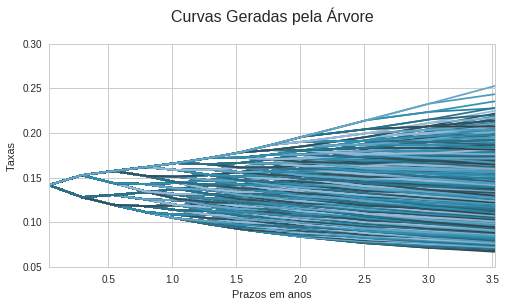

In [24]:
df_curves = pd.DataFrame(d_rtn)
ax1 = df_curves.T.plot(legend=False)
ax1.set_xlabel('Prazos em anos')
ax1.set_ylabel('Taxas')
ax1.set_title(u'Curvas Geradas pela Árvore\n', fontsize=16);

Por fim, ainda podemos visualizar todas os preços possíveis para o bond precificado. A distribuição lógicamente é centrada no preço de mercado do bond, por construção.

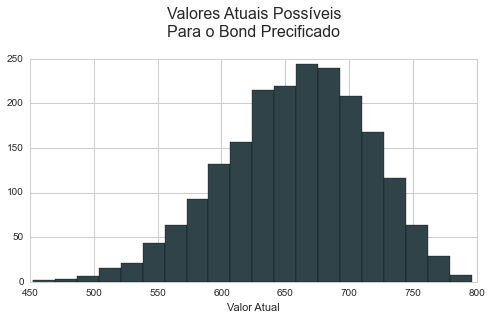

In [377]:
ax = df.hist(bins=20)
ax.set_xlabel("Valor Atual")
ax.set_title(u"Valores Atuais Possíveis\nPara o Bond Precificado\n", fontsize=16);

```
TODO: melhorar esse boloco
```
O curioso de tudo isso é que com apenas $91$ nós criados ao longo da áervore, é possível se obter o mesmo preço de todos  os $2048$ caminhos criados

## 3. Aplicação do Modelo

Nesta seção iremos ajustar a volatilidade do modelo e usar a curva criada para precificar diversos instrumentos.

### 3.1. Ajustando a Volatilidade

bla

In [380]:
# TODO: criar dispersão para diferentes volatilidades. mostrar que eh importante ter
# uma estimacaso crivel dela
#cria arvore
import binomial_tree; reload(binomial_tree)
d_vals = {}
bond_example = instruments.Bond(f_face_value=1000., f_cupon=0.)
for f_sig in [0.02, 0.05, 0.1, 0.2, 0.5, 0.8]:
    my_tree.fit_foward_curve(f_sigma=f_sig, f_faceval=1000.)
    df = bond_example.get_range_of_values(my_tree, i_steps=12)
    d_vals[f_sig] = list(df.values)

bla bla

In [383]:
df_sig = pd.DataFrame(d_vals)
df_sig.mean()

0.02    658.236155
0.05    658.236153
0.10    658.236151
0.20    658.236143
0.50    658.235491
0.80    658.215516
dtype: float64

bla bla

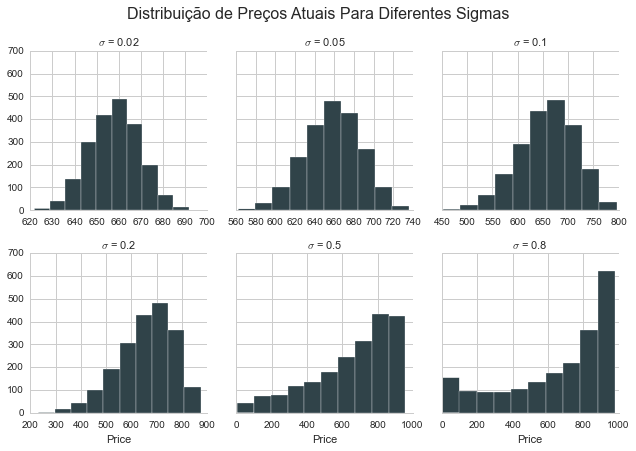

In [418]:
df2 = df_sig.stack().reset_index()
df2.columns = ["index", "$\sigma$", u"Price"]
g = sns.FacetGrid(df2, col="$\sigma$", col_wrap=3, margin_titles=True,
                  sharex=False, sharey=True, size=3)
g.map(plt.hist, 'Price', edgecolor='white')
g.fig.suptitle(u"Distribuição de Preços Atuais Para Diferentes Sigmas",
               fontsize=16, y=1.04);

### 3.2. Precificando Diferentes Instrumentos


bla bla

## 4. Conclusão

bla bla

O modelo poderia ser utilizado de maneira relevatnte para tomada de decisão em trade, desde que se achasse outro método para criar uma curva crível.  



## 5. Últimas Considerações

bla bla

Talvez se não mantesse todos os nós em memória fosse uma boa. Também criei todos os caminhos na força bruta, mas isso é inviável. Seria melhor criar a distrinuiçao ponderando cada valor pela respectiva probabilidade e criando uma distribuição hipotética

#### TODO:
- Implementar (OK)
- Levantar os preços histórico dos títulos: NTB (OK)
- Apresentar os principais pontos da abordagem (hipóteses, limitações e etc)
- detalhar o processo de calibração (juros e vol)
- Detalhar a determiação dos parâmetros do modelo ($\sigma$)
- Checar se tem base de dados de opções (Call Européia) de Juros
- Demonstrar a precificação de 2 derivativos mais complexos (opcional compara com mercado)


*Style notebook and change matplotlib defaults*

In [1]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [2]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))